In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, AveragePooling2D, BatchNormalization, Rescaling, Dropout
from tensorflow.keras.models import Sequential
from google.colab import drive


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b83bf8aa-41b8-49c3-01a3-6a6ee0c28d7b)


In [3]:
import multiprocessing

In [4]:
multiprocessing.cpu_count()

2

In [5]:
tf.random.set_seed(101)

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
# !pip install tensorflow-data-validation


In [182]:
#!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow_data_validation as tfdv

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
data_dir_train = pathlib.Path("./gdrive/MyDrive/melanoma_dataset/Train/")
data_dir_test = pathlib.Path('gdrive/MyDrive/melanoma_dataset/Test/')

In [6]:
os.listdir(data_dir_train)

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [7]:
os.listdir(data_dir_test)

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [8]:
os.listdir(str(data_dir_train)+'/nevus')[:5]

['ISIC_0000019.jpg',
 'ISIC_0000020.jpg',
 'ISIC_0000021.jpg',
 'ISIC_0000023.jpg',
 'ISIC_0000024.jpg']

In [9]:
len(list(data_dir_train.glob('*/*.jpg')))

2239

In [10]:
len(list(data_dir_test.glob('*/*.jpg')))

118

In [10]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3

In [8]:
## to make batched dataset
def make_ds(data_dir, subset, split = 0.2):
  ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir,
                                  seed=101,
                                  validation_split = split,
                                  subset = subset,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)
  return ds

In [9]:
# to visualise train v validation performance
def visualise_model_res(hist, epochs):
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [13]:
train_ds = make_ds(data_dir_train, 'training')
val_ds = make_ds(data_dir_train, 'validation')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
test_ds = make_ds(data_dir_test, None, None)

Found 118 files belonging to 9 classes.


In [15]:
classes = train_ds.class_names; classes

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [12]:
n_classes = len(classes); n_classes

9

In [17]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
summary = pd.DataFrame()
for d in [data_dir_train, data_dir_test]:
    for c in classes:
        n = len([i for i in 
                 pathlib.Path(f'{d}/{c}').glob('*.jpg')])
        summary.loc[c, d] = n
summary.columns = ['Train', 'Test']
summary.style.format("{:.0f}")

,Train,Test
actinic keratosis,114,16
basal cell carcinoma,376,16
dermatofibroma,95,16
melanoma,438,16
nevus,357,16
pigmented benign keratosis,462,16
seborrheic keratosis,77,3
squamous cell carcinoma,181,16
vascular lesion,139,3


##### We observe that there are 9 classes in the dataset. We have around ~2200 images that can be used for training (train/val). We also observe that our datset is imbalanced. Min/Max:
- keratosis - 77 samples
- pigmented benign keratosis	 - 462 samples

##### We'll explore augmentation and upsampling stratergies later in the NB to address these issues. 

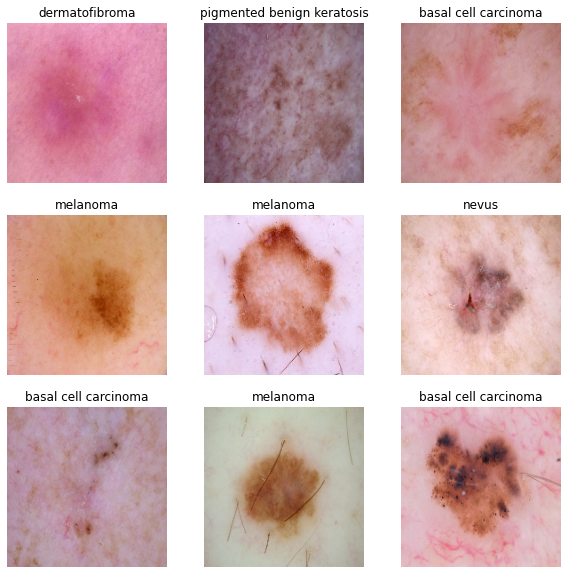

In [22]:
# visualising samples from each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 0 (Deeper Model)

In [21]:
model_0 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="auto",
    name="sparse_categorical_crossentropy",
)

In [20]:
optim = keras.optimizers.Adam(learning_rate=0.001)

In [24]:
model_0.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])

In [25]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

In [26]:
hist_0 = model_0.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 2,)


Epoch 1/20
56/56 - 233s - loss: 2.0105 - accuracy: 0.2087 - val_loss: 1.9132 - val_accuracy: 0.3065 - 233s/epoch - 4s/step
Epoch 2/20
56/56 - 3s - loss: 1.7869 - accuracy: 0.3398 - val_loss: 1.6336 - val_accuracy: 0.4139 - 3s/epoch - 49ms/step
Epoch 3/20
56/56 - 3s - loss: 1.6637 - accuracy: 0.4051 - val_loss: 1.6449 - val_accuracy: 0.4161 - 3s/epoch - 47ms/step
Epoch 4/20
56/56 - 3s - loss: 1.5672 - accuracy: 0.4420 - val_loss: 1.5379 - val_accuracy: 0.4228 - 3s/epoch - 47ms/step
Epoch 5/20
56/56 - 3s - loss: 1.4765 - accuracy: 0.4771 - val_loss: 1.5287 - val_accuracy: 0.4720 - 3s/epoch - 49ms/step
Epoch 6/20
56/56 - 3s - loss: 1.4467 - accuracy: 0.4972 - val_loss: 1.4634 - val_accuracy: 0.4944 - 3s/epoch - 47ms/step
Epoch 7/20
56/56 - 3s - loss: 1.3535 - accuracy: 0.5195 - val_loss: 1.4392 - val_accuracy: 0.4922 - 3s/epoch - 48ms/step
Epoch 8/20
56/56 - 3s - loss: 1.2975 - accuracy: 0.5541 - val_loss: 1.4078 - val_accuracy: 0.4989 - 3s/epoch - 48ms/step
Epoch 9/20
56/56 - 3s - loss: 

#### model 1 - reducing convolution layers (shallow model)

In [27]:
model_1 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [28]:
model_1.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])

In [30]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 43, 43, 64)       

In [31]:
hist_1 = model_1.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 1.9120 - accuracy: 0.2963 - val_loss: 1.7177 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6496 - accuracy: 0.3934 - val_loss: 1.5924 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5415 - accuracy: 0.4353 - val_loss: 1.5308 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4626 - accuracy: 0.4844 - val_loss: 1.5005 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4238 - accuracy: 0.4955 - val_loss: 1.4700 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3817 - accuracy: 0.5095 - val_loss: 1.4291 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2971 - accuracy: 0.5324 - val_loss: 1.4898 - val_accuracy: 0.4787
Epoch 8/20
56

#### model 2 - building upon model 1. trying first filter (1, 1)

In [32]:
model_2 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (1,1), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [33]:
model_2.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      64        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 43, 43, 64)       

In [34]:
hist_2 = model_2.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 2.0582 - accuracy: 0.2612 - val_loss: 1.8460 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6538 - accuracy: 0.3906 - val_loss: 1.6076 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5769 - accuracy: 0.4381 - val_loss: 1.5180 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4927 - accuracy: 0.4821 - val_loss: 1.4905 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4217 - accuracy: 0.5039 - val_loss: 1.4594 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3623 - accuracy: 0.5324 - val_loss: 1.3813 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3244 - accuracy: 0.5262 - val_loss: 1.4192 - val_accuracy: 0.5011
Epoch 8/20
56

#### model 3 - building upon model 1. trying 'same' padding in last convolution layer

In [35]:
model_3 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [36]:
model_3.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [37]:
hist_3 = model_3.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 2.4837 - accuracy: 0.1897 - val_loss: 2.0555 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0004 - accuracy: 0.2171 - val_loss: 2.0453 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9799 - accuracy: 0.2182 - val_loss: 2.1276 - val_accuracy: 0.2327
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9111 - accuracy: 0.2762 - val_loss: 1.8853 - val_accuracy: 0.3110
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.8344 - accuracy: 0.3025 - val_loss: 1.7434 - val_accuracy: 0.3512
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6562 - accuracy: 0.3895 - val_loss: 1.6326 - val_accuracy: 0.3579
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5405 - accuracy: 0.4325 - val_loss: 1.6086 - val_accuracy: 0.3893
Epoch 8/20
56

#### model 4 - building upon model 1. increasing the number of neuronns in FC layer

In [38]:
model_4 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [39]:
model_4.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 43, 43, 64)       

In [40]:
hist_4 = model_4.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 2.2713 - accuracy: 0.1830 - val_loss: 1.9763 - val_accuracy: 0.2461
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0323 - accuracy: 0.2076 - val_loss: 2.0465 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9889 - accuracy: 0.2176 - val_loss: 1.9916 - val_accuracy: 0.2640
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9366 - accuracy: 0.2444 - val_loss: 2.0046 - val_accuracy: 0.2304
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9397 - accuracy: 0.2310 - val_loss: 1.9987 - val_accuracy: 0.2550
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8566 - accuracy: 0.2773 - val_loss: 1.9534 - val_accuracy: 0.2640
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7958 - accuracy: 0.3058 - val_loss: 1.8968 - val_accuracy: 0.2908
Epoch 8/20
56

#### Amongst the 5 models we've built so far, model 1 has performed the best

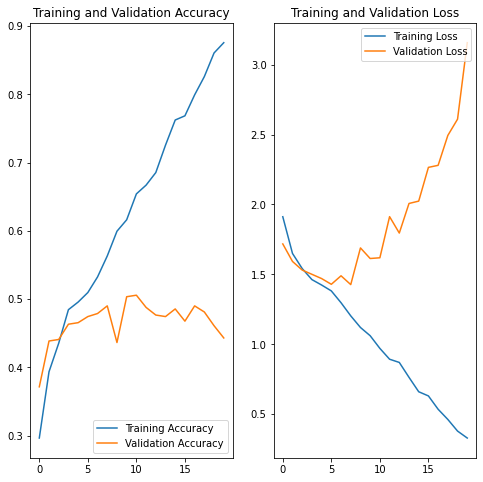

In [141]:
visualise_model_res(hist_1, 20)

#### We observe that the best model converges at around 3 epochs, post which it starts to overfit the train data. We'll try to fix. this

##### We will first experiment with adding dropout only on after the FC layer, as suggested in the original paper by Geoff Hinton

In [56]:
model_1_dropout = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.25),
    Dense(n_classes, activation = 'softmax'),
])

In [57]:
model_1_dropout.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_1_dropout.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 43, 43, 64)       

In [58]:
hist_1_dropout = model_1_dropout.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 2.1634 - accuracy: 0.1959 - val_loss: 1.9975 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.8644 - accuracy: 0.3041 - val_loss: 1.8192 - val_accuracy: 0.3423
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7766 - accuracy: 0.3309 - val_loss: 1.7776 - val_accuracy: 0.3289
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7276 - accuracy: 0.3438 - val_loss: 1.7266 - val_accuracy: 0.3803
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6741 - accuracy: 0.3811 - val_loss: 1.6779 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6376 - accuracy: 0.4057 - val_loss: 1.6189 - val_accuracy: 0.4094
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5887 - accuracy: 0.4247 - val_loss: 1.5887 - val_accuracy: 0.4139
Epoch 8/20
56

#### adding another FC layer

In [59]:
model_1_dropout_1 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.25),
    Dense(128, activation = 'relu'),
    Dropout(0.125),
    Dense(n_classes, activation = 'softmax'),
])

In [60]:
model_1_dropout_1.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_1_dropout_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 43, 43, 64)      

In [61]:
hist_1_dropout_1 = model_1_dropout_1.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 2.1196 - accuracy: 0.2182 - val_loss: 1.9710 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9954 - accuracy: 0.2344 - val_loss: 2.0620 - val_accuracy: 0.2013
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 2.0150 - accuracy: 0.2037 - val_loss: 2.0524 - val_accuracy: 0.2013
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0118 - accuracy: 0.1987 - val_loss: 2.0616 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0131 - accuracy: 0.2009 - val_loss: 2.0504 - val_accuracy: 0.2103
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0122 - accuracy: 0.2031 - val_loss: 2.0470 - val_accuracy: 0.2103
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9964 - accuracy: 0.2093 - val_loss: 2.0389 - val_accuracy: 0.2148
Epoch 8/20
56

#### Adding another FC layer din't produce very good results

#### Trying Augmentation Strategies

In [124]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomBrightness(factor=0.2)
])

#### Original images

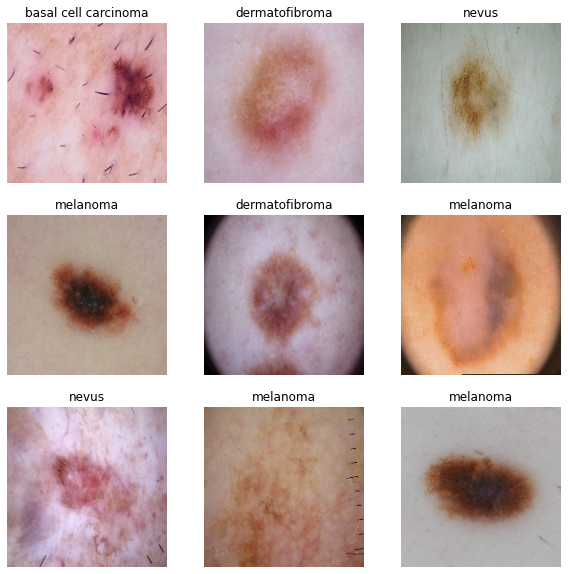

In [106]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [107]:
aug_img = data_augmentation(images, training= True)

#### Augmented Images
 - We will use an augmentaion. layer within the model

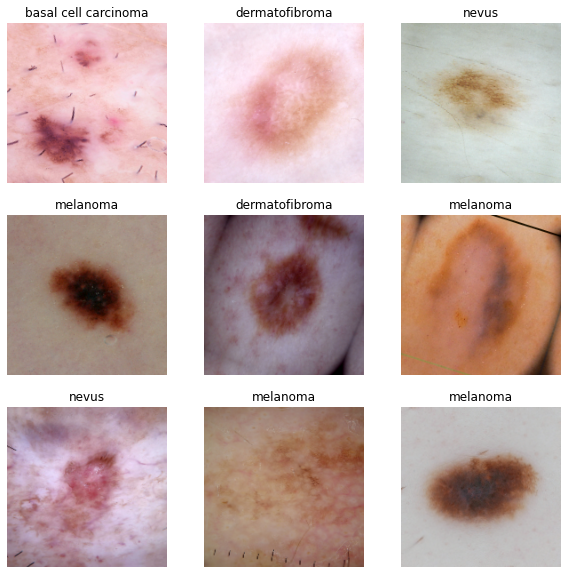

In [108]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [155]:
model_aug_0 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [156]:
model_aug_0.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_0.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_26 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [153]:
hist_aug_0 = model_aug_0.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')


Epoch 1/20
56/56 [==============================] - 4s 48ms/step - loss: 2.2549 - accuracy: 0.1747 - val_loss: 2.0561 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 2.0137 - accuracy: 0.2015 - val_loss: 2.0511 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 2.0099 - accuracy: 0.1975 - val_loss: 2.0451 - val_accuracy: 0.2013
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.9978 - accuracy: 0.2081 - val_loss: 2.0464 - val_accuracy: 0.2013
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.9853 - accuracy: 0.2405 - val_loss: 2.0087 - val_accuracy: 0.3244
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.9287 - accuracy: 0.2930 - val_loss: 1.9190 - val_accuracy: 0.2886
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.8119 - accuracy: 0.3348 - val_loss: 1.8596 - val_accuracy: 0.3333
Epoch 8/20
56

In [128]:
model_aug_1 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

#### Trying a deeper model

In [129]:
model_aug_1.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_58 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 90, 90, 32)        4640      
                                                     

In [130]:
hist_aug_1 = model_aug_1.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')

Epoch 1/20
56/56 [==============================] - 5s 74ms/step - loss: 2.1575 - accuracy: 0.1936 - val_loss: 2.0484 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0179 - accuracy: 0.1964 - val_loss: 2.0528 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0108 - accuracy: 0.2059 - val_loss: 2.0829 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0124 - accuracy: 0.2059 - val_loss: 2.0524 - val_accuracy: 0.2013
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 2.0122 - accuracy: 0.1948 - val_loss: 2.0598 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0105 - accuracy: 0.1992 - val_loss: 2.0582 - val_accuracy: 0.2081
Epoch 7/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0121 - accuracy: 0.1981 - val_loss: 2.0532 - val_accuracy: 0.2081
Epoch 8/20
56

#### Removing maxpooling layers

In [131]:
model_aug_2 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [132]:
model_aug_2.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_64 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 conv2d_65 (Conv2D)          (None, 178, 178, 64)      18496     
                                                                 
 flatten_17 (Flatten)        (None, 2027776)           0         
                                                                 
 dense_35 (Dense)            (None, 128)             

### Trying a model without Maxpooling layers

In [133]:
hist_aug_2 = model_aug_2.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')

Epoch 1/20
56/56 [==============================] - 12s 181ms/step - loss: 40.7217 - accuracy: 0.1970 - val_loss: 2.0828 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 9s 167ms/step - loss: 2.0288 - accuracy: 0.1942 - val_loss: 2.0479 - val_accuracy: 0.2013
Epoch 3/20
56/56 [==============================] - 10s 177ms/step - loss: 2.0081 - accuracy: 0.1981 - val_loss: 2.0514 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 10s 183ms/step - loss: 2.0073 - accuracy: 0.1948 - val_loss: 2.0530 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 9s 169ms/step - loss: 2.0072 - accuracy: 0.2059 - val_loss: 2.0530 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 9s 168ms/step - loss: 2.0069 - accuracy: 0.2059 - val_loss: 2.0531 - val_accuracy: 0.2081
Epoch 7/20
56/56 [==============================] - 9s 167ms/step - loss: 2.0065 - accuracy: 0.2059 - val_loss: 2.0526 - val_accuracy: 0.2081
Ep

KeyboardInterrupt: ignored

In [134]:
model_aug_3 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [135]:
model_aug_3.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

### using same padding in all concolution layers

In [136]:
hist_aug_3 = model_aug_3.fit(train_ds, validation_data = val_ds, epochs = 20, verbose= 'auto')

Epoch 1/20
56/56 [==============================] - 4s 50ms/step - loss: 2.3346 - accuracy: 0.1987 - val_loss: 2.0739 - val_accuracy: 0.2170
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 2.0034 - accuracy: 0.2305 - val_loss: 2.0655 - val_accuracy: 0.1991
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9720 - accuracy: 0.2573 - val_loss: 1.9838 - val_accuracy: 0.2617
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9355 - accuracy: 0.2511 - val_loss: 2.0098 - val_accuracy: 0.2394
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9612 - accuracy: 0.2500 - val_loss: 1.9756 - val_accuracy: 0.2438
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9352 - accuracy: 0.2578 - val_loss: 1.9673 - val_accuracy: 0.2595
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9245 - accuracy: 0.2595 - val_loss: 1.9589 - val_accuracy: 0.2573
Epoch 8/20
56

In [143]:
#### more neurons in Dense layer

#### more neurons in Dense layer

In [167]:
model_aug_4 = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(n_classes, activation = 'softmax'),
])

In [168]:
model_aug_4.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_4.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_30 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_93 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [139]:
hist_aug_4 = model_aug_4.fit(train_ds, validation_data = val_ds, epochs = 30, verbose= 'auto')

Epoch 1/30
56/56 [==============================] - 4s 51ms/step - loss: 2.7604 - accuracy: 0.1925 - val_loss: 2.0676 - val_accuracy: 0.2013
Epoch 2/30
56/56 [==============================] - 3s 46ms/step - loss: 2.0184 - accuracy: 0.1959 - val_loss: 2.0571 - val_accuracy: 0.2081
Epoch 3/30
56/56 [==============================] - 3s 53ms/step - loss: 2.0112 - accuracy: 0.1942 - val_loss: 2.0520 - val_accuracy: 0.2081
Epoch 4/30
56/56 [==============================] - 4s 66ms/step - loss: 2.0115 - accuracy: 0.2059 - val_loss: 2.0542 - val_accuracy: 0.2081
Epoch 5/30
56/56 [==============================] - 3s 59ms/step - loss: 2.0115 - accuracy: 0.1992 - val_loss: 2.0590 - val_accuracy: 0.2081
Epoch 6/30
56/56 [==============================] - 3s 62ms/step - loss: 2.0107 - accuracy: 0.1970 - val_loss: 2.0489 - val_accuracy: 0.2081
Epoch 7/30
56/56 [==============================] - 3s 55ms/step - loss: 2.0082 - accuracy: 0.2054 - val_loss: 2.0497 - val_accuracy: 0.2103
Epoch 8/30
56

#### Training our best model, `model_aug_0` & `model_aug_4` with more epochs

In [157]:
hist_aug_0 = model_aug_0.fit(train_ds, validation_data = val_ds, epochs = 60, verbose= 'auto')


Epoch 1/60
56/56 [==============================] - 4s 50ms/step - loss: 2.0671 - accuracy: 0.1853 - val_loss: 2.0680 - val_accuracy: 0.1521
Epoch 2/60
56/56 [==============================] - 3s 46ms/step - loss: 2.0207 - accuracy: 0.1959 - val_loss: 2.0531 - val_accuracy: 0.2081
Epoch 3/60
56/56 [==============================] - 3s 45ms/step - loss: 2.0106 - accuracy: 0.1959 - val_loss: 2.0400 - val_accuracy: 0.2192
Epoch 4/60
56/56 [==============================] - 3s 55ms/step - loss: 1.9970 - accuracy: 0.2132 - val_loss: 2.0181 - val_accuracy: 0.2506
Epoch 5/60
56/56 [==============================] - 4s 63ms/step - loss: 1.9226 - accuracy: 0.2723 - val_loss: 1.9522 - val_accuracy: 0.2617
Epoch 6/60
56/56 [==============================] - 3s 57ms/step - loss: 1.8594 - accuracy: 0.2879 - val_loss: 1.8740 - val_accuracy: 0.3154
Epoch 7/60
56/56 [==============================] - 4s 70ms/step - loss: 1.7890 - accuracy: 0.3248 - val_loss: 1.7378 - val_accuracy: 0.3848
Epoch 8/60
56

In [169]:
hist_aug_4 = model_aug_4.fit(train_ds, validation_data = val_ds, epochs = 60, verbose= 'auto')


Epoch 1/60
56/56 [==============================] - 4s 48ms/step - loss: 2.2981 - accuracy: 0.1987 - val_loss: 2.0617 - val_accuracy: 0.2081
Epoch 2/60
56/56 [==============================] - 3s 49ms/step - loss: 2.0157 - accuracy: 0.2115 - val_loss: 2.0609 - val_accuracy: 0.1521
Epoch 3/60
56/56 [==============================] - 2s 44ms/step - loss: 2.0087 - accuracy: 0.1936 - val_loss: 1.9969 - val_accuracy: 0.2595
Epoch 4/60
56/56 [==============================] - 2s 44ms/step - loss: 1.8797 - accuracy: 0.2846 - val_loss: 1.8278 - val_accuracy: 0.3043
Epoch 5/60
56/56 [==============================] - 2s 44ms/step - loss: 1.8261 - accuracy: 0.3092 - val_loss: 1.7675 - val_accuracy: 0.3602
Epoch 6/60
56/56 [==============================] - 2s 45ms/step - loss: 1.7203 - accuracy: 0.3929 - val_loss: 1.6108 - val_accuracy: 0.4228
Epoch 7/60
56/56 [==============================] - 2s 44ms/step - loss: 1.6748 - accuracy: 0.3834 - val_loss: 1.6746 - val_accuracy: 0.3647
Epoch 8/60
56

#### Adding dropout to model_aug_4 to control overfitting

In [173]:
model_aug_4_dr = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.1),
    Dense(n_classes, activation = 'softmax'),
])

In [174]:
model_aug_4_dr.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_4_dr.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_32 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_99 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [175]:
hist_aug_4_dr = model_aug_4_dr.fit(train_ds, validation_data = val_ds, epochs = 60, verbose= 'auto')


Epoch 1/60
56/56 [==============================] - 4s 49ms/step - loss: 2.3805 - accuracy: 0.2193 - val_loss: 2.0380 - val_accuracy: 0.2394
Epoch 2/60
56/56 [==============================] - 2s 44ms/step - loss: 1.9567 - accuracy: 0.2416 - val_loss: 1.9591 - val_accuracy: 0.2192
Epoch 3/60
56/56 [==============================] - 2s 44ms/step - loss: 1.9183 - accuracy: 0.2868 - val_loss: 1.9456 - val_accuracy: 0.2662
Epoch 4/60
56/56 [==============================] - 2s 44ms/step - loss: 1.8642 - accuracy: 0.2980 - val_loss: 1.9836 - val_accuracy: 0.2707
Epoch 5/60
56/56 [==============================] - 2s 45ms/step - loss: 1.8627 - accuracy: 0.2946 - val_loss: 1.9162 - val_accuracy: 0.2550
Epoch 6/60
56/56 [==============================] - 2s 44ms/step - loss: 1.8219 - accuracy: 0.3103 - val_loss: 1.8525 - val_accuracy: 0.2864
Epoch 7/60
56/56 [==============================] - 2s 45ms/step - loss: 1.7922 - accuracy: 0.3175 - val_loss: 1.8272 - val_accuracy: 0.3266
Epoch 8/60
56

In [176]:
model_aug_4_dr_bn = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    data_augmentation,
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.1),
    Dense(n_classes, activation = 'softmax'),
])

In [177]:
model_aug_4_dr_bn.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_aug_4_dr_bn.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_33 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_102 (Conv2D)         (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 90, 90, 32)      

In [178]:
hist_aug_4_dr_bn = model_aug_4_dr_bn.fit(train_ds, validation_data = val_ds, epochs = 60, verbose= 'auto')


Epoch 1/60
56/56 [==============================] - 5s 58ms/step - loss: 9.2831 - accuracy: 0.2277 - val_loss: 54.7214 - val_accuracy: 0.2081
Epoch 2/60
56/56 [==============================] - 3s 50ms/step - loss: 2.0582 - accuracy: 0.2444 - val_loss: 22.3671 - val_accuracy: 0.0850
Epoch 3/60
56/56 [==============================] - 3s 50ms/step - loss: 1.9964 - accuracy: 0.2528 - val_loss: 23.8678 - val_accuracy: 0.1342
Epoch 4/60
56/56 [==============================] - 3s 50ms/step - loss: 1.9103 - accuracy: 0.3080 - val_loss: 22.3537 - val_accuracy: 0.1655
Epoch 5/60
56/56 [==============================] - 3s 51ms/step - loss: 1.7731 - accuracy: 0.3588 - val_loss: 16.6651 - val_accuracy: 0.1678
Epoch 6/60
56/56 [==============================] - 3s 57ms/step - loss: 1.7705 - accuracy: 0.3465 - val_loss: 11.0278 - val_accuracy: 0.1924
Epoch 7/60
56/56 [==============================] - 3s 50ms/step - loss: 1.7458 - accuracy: 0.3544 - val_loss: 6.5543 - val_accuracy: 0.2349
Epoch 8

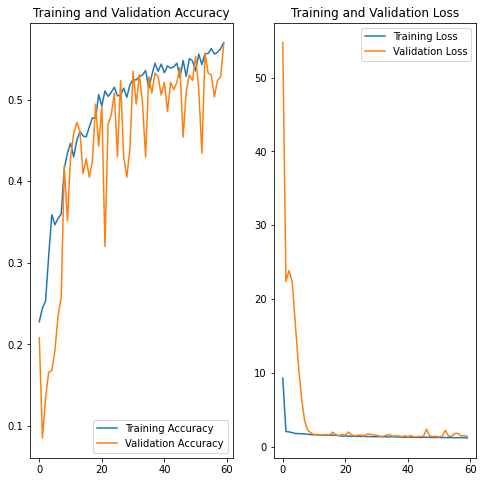

In [179]:
visualise_model_res(hist_aug_4_dr_bn, 60)

This is one of our best models using augmentaion. we're not doing perticulary well in terms of error and loss

#### Fixing class imbalance
- We had observed the class imbalance earlier. We'll now try to fix that with and random augmentation upsampling

In [184]:
summary

,Train,Test
actinic keratosis,114.0,16.0
basal cell carcinoma,376.0,16.0
dermatofibroma,95.0,16.0
melanoma,438.0,16.0
nevus,357.0,16.0
pigmented benign keratosis,462.0,16.0
seborrheic keratosis,77.0,3.0
squamous cell carcinoma,181.0,16.0
vascular lesion,139.0,3.0


##### appending the augmented data to the original data

In [190]:
# generating augmented data
path_to_training_dataset= './gdrive/MyDrive/melanoma_dataset/Train/'
import Augmentor
for i in classes:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 114 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F66367AEC10>: 100%|██████████| 1000/1000 [00:36<00:00, 27.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6637873D50>: 100%|██████████| 1000/1000 [00:35<00:00, 28.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F672A896E50>: 100%|██████████| 1000/1000 [00:35<00:00, 28.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F66378736D0>: 100%|██████████| 1000/1000 [02:41<00:00,  6.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F66C61E0CD0>: 100%|██████████| 1000/1000 [02:29<00:00,  6.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F66433B08D0>: 100%|██████████| 1000/1000 [00:35<00:00, 28.28 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6637BDC210>: 100%|██████████| 1000/1000 [01:22<00:00, 12.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F672AC02B90>: 100%|██████████| 1000/1000 [00:35<00:00, 28.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./gdrive/MyDrive/melanoma_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6637958110>: 100%|██████████| 1000/1000 [00:35<00:00, 28.22 Samples/s]


In [191]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [193]:
import glob, shutil

In [200]:
os.path.join(data_dir_train, '*','output', '*.jpg')

'gdrive/MyDrive/melanoma_dataset/Train/*/output/*.jpg'

In [222]:
from pathlib import Path
import shutil

for i in classes:
  print(f'moving class - {i}')
  src_path = f'./gdrive/MyDrive/melanoma_dataset/Train/{i}/output/'
  trg_path = f'./gdrive/MyDrive/melanoma_dataset/Train/{i}/'

  for src_file in Path(src_path).glob('*.jpg'):
      shutil.copy(src_file, trg_path)

moving class - actinic keratosis
moving class - basal cell carcinoma
moving class - dermatofibroma
moving class - melanoma
moving class - nevus
moving class - pigmented benign keratosis
moving class - seborrheic keratosis
moving class - squamous cell carcinoma
moving class - vascular lesion


In [250]:
from pathlib import Path
import shutil

for i in classes:
  trg_path = f'./gdrive/MyDrive/melanoma_dataset/Train/{i}/output/'
  print(f'removing class - {trg_path}')

  shutil.rmtree(trg_path)

removing class - ./gdrive/MyDrive/melanoma_dataset/Train/actinic keratosis/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/basal cell carcinoma/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/dermatofibroma/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/melanoma/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/nevus/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/pigmented benign keratosis/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/seborrheic keratosis/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/squamous cell carcinoma/output/
removing class - ./gdrive/MyDrive/melanoma_dataset/Train/vascular lesion/output/


In [213]:
list(data_dir_train.glob('actinic keratosis/.*jpg'))

[]

In [246]:
src_path = f'./gdrive/MyDrive/melanoma_dataset/Train/squamous cell carcinoma/output/'
trg_path = f'./gdrive/MyDrive/melanoma_dataset/Train/squamous cell carcinoma/'

for src_file in Path(src_path).glob('*.jpg'):
    shutil.copy(src_file, trg_path)

In [248]:
!ls gdrive/MyDrive/melanoma_dataset/Train/vascular\ lesion | wc -l

1140


In [251]:
!rm drive/MyDrive/melanoma_dataset/Train/actinic keratosis/output/ -rf 

In [209]:
image_count_train = len(list(data_dir_train.glob('actinic keratosis/.*jpg')))
print(image_count_train)

0


In [ ]:
shutil.move("gdrive/MyDrive/melanoma_dataset/Train/{i}/output/*", "gdrive/MyDrive/melanoma_dataset/Train/{i}/")


In [203]:
classes

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [206]:
!mv "gdrive/MyDrive/melanoma_dataset/Train/nevus/output/*.jpg" "gdrive/MyDrive/melanoma_dataset/Train/nevus/"


mv: cannot stat 'gdrive/MyDrive/melanoma_dataset/Train/nevus/output/*.jpg': No such file or directory


In [13]:
summary = pd.DataFrame()
for d in [data_dir_train, data_dir_test]:
    for c in classes:
        n = len([i for i in 
                 pathlib.Path(f'{d}/{c}').glob('*.jpg')])
        summary.loc[c, d] = n
summary.columns = ['Train', 'Test']
summary.style.format("{:.0f}")

,Train,Test
actinic keratosis,1114,16
basal cell carcinoma,1376,16
dermatofibroma,1095,16
melanoma,1438,16
nevus,1357,16
pigmented benign keratosis,1462,16
seborrheic keratosis,1077,3
squamous cell carcinoma,1181,16
vascular lesion,1139,3


##### we see that we've succesfully augmented and upsampled our data. though slight imbalance still remains which is intended

#### Searching for best model with Augmented Data

In [12]:
train_ds_new = make_ds(data_dir_train, 'training')
val_ds_new = make_ds(data_dir_train, 'validation')

Found 11239 files belonging to 9 classes.
Using 8992 files for training.
Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [20]:
model_0_upsampled = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.1),
    Dense(n_classes, activation = 'softmax'),
])

In [22]:
model_0_upsampled.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_0_upsampled.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)      

In [23]:
hist_0_upsampled = model_0_upsampled.fit(train_ds_new, validation_data = val_ds_new, epochs = 20, verbose= 'auto',)

Epoch 1/20
281/281 [==============================] - 3053s 11s/step - loss: 2.0272 - accuracy: 0.3770 - val_loss: 17.7148 - val_accuracy: 0.1322
Epoch 2/20
281/281 [==============================] - 45s 157ms/step - loss: 1.2568 - accuracy: 0.5118 - val_loss: 2.3664 - val_accuracy: 0.3979
Epoch 3/20
281/281 [==============================] - 46s 160ms/step - loss: 0.9965 - accuracy: 0.6042 - val_loss: 3.2364 - val_accuracy: 0.3062
Epoch 4/20
281/281 [==============================] - 45s 156ms/step - loss: 0.8261 - accuracy: 0.6749 - val_loss: 1.8726 - val_accuracy: 0.4499
Epoch 5/20
281/281 [==============================] - 45s 156ms/step - loss: 0.6553 - accuracy: 0.7417 - val_loss: 0.7315 - val_accuracy: 0.7316
Epoch 6/20
281/281 [==============================] - 45s 156ms/step - loss: 0.5512 - accuracy: 0.7827 - val_loss: 0.9164 - val_accuracy: 0.6800
Epoch 7/20
281/281 [==============================] - 46s 159ms/step - loss: 0.4673 - accuracy: 0.8188 - val_loss: 0.6530 - val_a

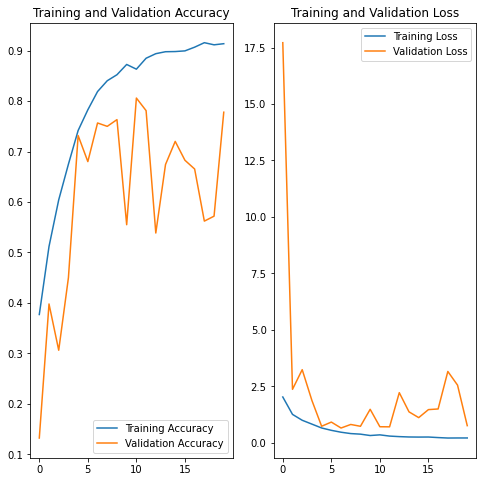

In [24]:
visualise_model_res(hist_0_upsampled, 20)

In [25]:
model_0_upsampled.evaluate(test_ds)

4/4 [==============================] - 40s 69ms/step - loss: 5.8223 - accuracy: 0.3559


[5.822333812713623, 0.35593220591545105]

In [27]:
model_1_upsampled = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.25),
    Dense(n_classes, activation = 'softmax'),
])

In [28]:
model_1_upsampled.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_1_upsampled.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_7 (Batc  (None, 90, 90, 32)      

In [29]:
hist_1_upsampled = model_1_upsampled.fit(train_ds_new, validation_data = val_ds_new, epochs = 20, verbose= 'auto',)

Epoch 1/20
281/281 [==============================] - 47s 160ms/step - loss: 5.3261 - accuracy: 0.1887 - val_loss: 33.3356 - val_accuracy: 0.1148
Epoch 2/20
281/281 [==============================] - 46s 157ms/step - loss: 1.9389 - accuracy: 0.2221 - val_loss: 1.8328 - val_accuracy: 0.2470
Epoch 3/20
281/281 [==============================] - 45s 156ms/step - loss: 1.8838 - accuracy: 0.2286 - val_loss: 2.4299 - val_accuracy: 0.1945
Epoch 4/20
281/281 [==============================] - 46s 161ms/step - loss: 1.8286 - accuracy: 0.2439 - val_loss: 1.7047 - val_accuracy: 0.2586
Epoch 5/20
281/281 [==============================] - 45s 157ms/step - loss: 1.7686 - accuracy: 0.2695 - val_loss: 1.7511 - val_accuracy: 0.3316
Epoch 6/20
281/281 [==============================] - 45s 157ms/step - loss: 1.7508 - accuracy: 0.2923 - val_loss: 2.1646 - val_accuracy: 0.2888
Epoch 7/20
281/281 [==============================] - 45s 157ms/step - loss: 1.6152 - accuracy: 0.3582 - val_loss: 2.7421 - val_a

In [30]:
model_1_upsampled.evaluate(test_ds)

4/4 [==============================] - 4s 15ms/step - loss: 5.2325 - accuracy: 0.2627


[5.2324604988098145, 0.26271185278892517]

In [31]:
model_2_upsampled = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.1),
    Dense(n_classes, activation = 'softmax'),
])

In [32]:
model_2_upsampled.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_2_upsampled.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_10 (Bat  (None, 90, 90, 32)      

In [33]:
hist_2_upsampled = model_2_upsampled.fit(train_ds_new, validation_data = val_ds_new, epochs = 20, verbose= 'auto',)

Epoch 1/20
281/281 [==============================] - 46s 157ms/step - loss: 3.8440 - accuracy: 0.2776 - val_loss: 2.9137 - val_accuracy: 0.1713
Epoch 2/20
281/281 [==============================] - 47s 164ms/step - loss: 1.4435 - accuracy: 0.4218 - val_loss: 1.6779 - val_accuracy: 0.3747
Epoch 3/20
281/281 [==============================] - 45s 156ms/step - loss: 1.2758 - accuracy: 0.5031 - val_loss: 1.6586 - val_accuracy: 0.4397
Epoch 4/20
281/281 [==============================] - 45s 155ms/step - loss: 1.0956 - accuracy: 0.5802 - val_loss: 1.1554 - val_accuracy: 0.5465
Epoch 5/20
281/281 [==============================] - 46s 160ms/step - loss: 0.9213 - accuracy: 0.6470 - val_loss: 0.9665 - val_accuracy: 0.6360
Epoch 6/20
281/281 [==============================] - 45s 155ms/step - loss: 0.7661 - accuracy: 0.7080 - val_loss: 1.5133 - val_accuracy: 0.5194
Epoch 7/20
281/281 [==============================] - 45s 156ms/step - loss: 0.6527 - accuracy: 0.7524 - val_loss: 0.6541 - val_ac

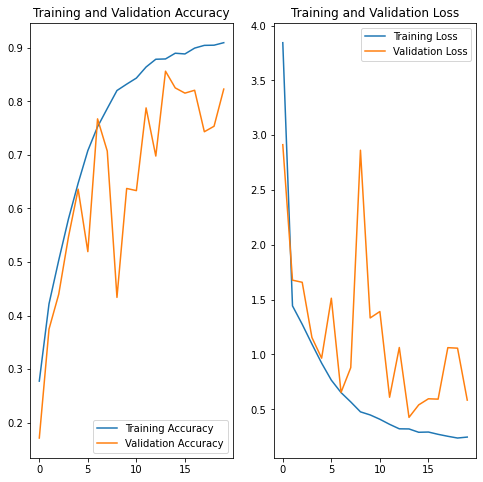

In [34]:
visualise_model_res(hist_2_upsampled, 20)

In [35]:
model_2_upsampled.evaluate(test_ds)

4/4 [==============================] - 4s 15ms/step - loss: 5.3240 - accuracy: 0.3051


[5.323992729187012, 0.3050847351551056]

In [36]:
model_3_upsampled = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.05),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.1),
    Dense(n_classes, activation = 'softmax'),
])

In [37]:
model_3_upsampled.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_3_upsampled.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_13 (Bat  (None, 90, 90, 32)      

In [38]:
hist_3_upsampled = model_3_upsampled.fit(train_ds_new, validation_data = val_ds_new, epochs = 20, verbose= 'auto',)

Epoch 1/20
281/281 [==============================] - 46s 158ms/step - loss: 4.4332 - accuracy: 0.1981 - val_loss: 33.1136 - val_accuracy: 0.2012
Epoch 2/20
281/281 [==============================] - 45s 156ms/step - loss: 1.7513 - accuracy: 0.3084 - val_loss: 2.7949 - val_accuracy: 0.2857
Epoch 3/20
281/281 [==============================] - 46s 161ms/step - loss: 1.5450 - accuracy: 0.3655 - val_loss: 1.6950 - val_accuracy: 0.3409
Epoch 4/20
281/281 [==============================] - 45s 156ms/step - loss: 1.4574 - accuracy: 0.4018 - val_loss: 1.3213 - val_accuracy: 0.4664
Epoch 5/20
281/281 [==============================] - 45s 156ms/step - loss: 1.3970 - accuracy: 0.4294 - val_loss: 2.0859 - val_accuracy: 0.2644
Epoch 6/20
281/281 [==============================] - 46s 160ms/step - loss: 1.3126 - accuracy: 0.4661 - val_loss: 1.2793 - val_accuracy: 0.4927
Epoch 7/20
281/281 [==============================] - 45s 155ms/step - loss: 1.2421 - accuracy: 0.5021 - val_loss: 1.1526 - val_a

In [39]:
model_3_upsampled.evaluate(test_ds)

4/4 [==============================] - 4s 15ms/step - loss: 13.1552 - accuracy: 0.3644


[13.155200004577637, 0.3644067943096161]

In [40]:
model_4_upsampled = Sequential([
    Rescaling(1./255, input_shape = (img_height, img_width, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer='l2'),
    Dropout(0.1),
    Dense(n_classes, activation = 'softmax'),
])

In [41]:
model_4_upsampled.compile(loss = loss_fn, optimizer= optim, metrics = ['accuracy'])
model_4_upsampled.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_15 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_16 (Bat  (None, 90, 90, 32)      

In [42]:
hist_4_upsampled = model_4_upsampled.fit(train_ds_new, validation_data = val_ds_new, epochs = 30, verbose= 'auto',)

Epoch 1/30
281/281 [==============================] - 46s 159ms/step - loss: 11.2188 - accuracy: 0.2621 - val_loss: 2.3702 - val_accuracy: 0.2052
Epoch 2/30
281/281 [==============================] - 46s 160ms/step - loss: 1.8871 - accuracy: 0.3241 - val_loss: 1.8474 - val_accuracy: 0.3258
Epoch 3/30
281/281 [==============================] - 45s 155ms/step - loss: 1.7420 - accuracy: 0.3424 - val_loss: 1.5821 - val_accuracy: 0.4028
Epoch 4/30
281/281 [==============================] - 45s 156ms/step - loss: 1.6742 - accuracy: 0.3618 - val_loss: 1.5599 - val_accuracy: 0.3974
Epoch 5/30
281/281 [==============================] - 46s 161ms/step - loss: 1.6650 - accuracy: 0.3603 - val_loss: 1.4990 - val_accuracy: 0.4028
Epoch 6/30
281/281 [==============================] - 45s 157ms/step - loss: 1.6279 - accuracy: 0.3811 - val_loss: 1.5678 - val_accuracy: 0.4094
Epoch 7/30
281/281 [==============================] - 45s 155ms/step - loss: 1.6142 - accuracy: 0.4041 - val_loss: 1.5472 - val_a

In [43]:
model_4_upsampled.evaluate(test_ds)

4/4 [==============================] - 4s 15ms/step - loss: 3.4701 - accuracy: 0.3814


[3.470055103302002, 0.3813559412956238]

### Best model

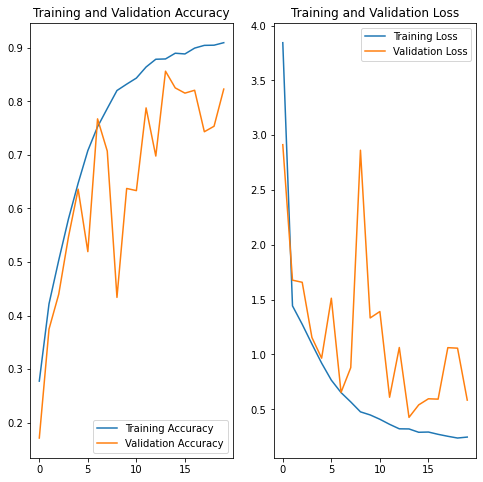

In [44]:
visualise_model_res(hist_2_upsampled, 20)

##### We observe that our best model using augmented data gives converges at around 12 epochs train and validation accuracy close to 0.9
##### The model is still not able to perform very well on the test data, probably due to limted data in test data

#### Extra - Transfer Learning

In [15]:
n_classes  = len(train_ds_new.class_names); n_classes

9

In [40]:
resnet_tl = Sequential()

res50= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in res50.layers:
        layer.trainable=False

resnet_tl.add(res50)


In [41]:
resnet_tl.add(Flatten())
resnet_tl.add(Dense(256, activation='relu'))
resnet_tl.add(Dense(n_classes, activation='softmax'))


In [42]:
resnet_tl.compile(optimizer = optim,loss=loss_fn ,metrics=['accuracy'])

In [43]:
resnet_tl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dense_13 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 24,114,569
Trainable params: 526,857
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
history_tl_o = resnet_tl.fit(train_ds_new, validation_data=val_ds_new, epochs=10)

Epoch 1/10
281/281 [==============================] - 3768s 13s/step - loss: 1.1500 - accuracy: 0.5876 - val_loss: 0.7799 - val_accuracy: 0.7272
Epoch 2/10
281/281 [==============================] - 51s 177ms/step - loss: 0.6311 - accuracy: 0.7750 - val_loss: 0.5357 - val_accuracy: 0.8202
Epoch 3/10
281/281 [==============================] - 51s 178ms/step - loss: 0.4504 - accuracy: 0.8425 - val_loss: 0.4571 - val_accuracy: 0.8451
Epoch 4/10
281/281 [==============================] - 52s 181ms/step - loss: 0.3378 - accuracy: 0.8835 - val_loss: 0.4280 - val_accuracy: 0.8634
Epoch 5/10
281/281 [==============================] - 51s 177ms/step - loss: 0.2797 - accuracy: 0.9017 - val_loss: 0.3473 - val_accuracy: 0.8678
Epoch 6/10
281/281 [==============================] - 52s 183ms/step - loss: 0.2341 - accuracy: 0.9174 - val_loss: 0.3682 - val_accuracy: 0.8741
Epoch 7/10
281/281 [==============================] - 51s 179ms/step - loss: 0.2132 - accuracy: 0.9244 - val_loss: 0.2994 - val_ac

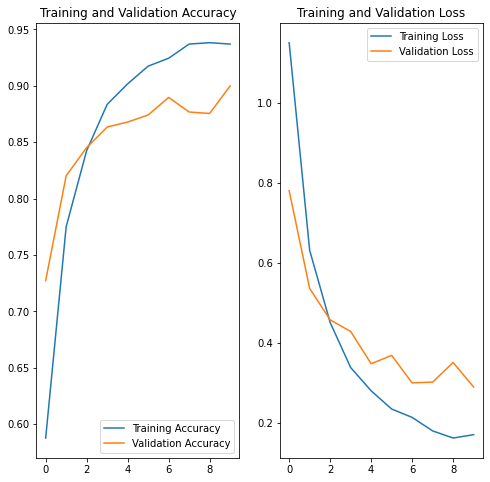

In [45]:
visualise_model_res(history_tl_o, 10)

In [46]:
resnet_tl.evaluate(test_ds)

4/4 [==============================] - 53s 260ms/step - loss: 3.4675 - accuracy: 0.4068


[3.4674642086029053, 0.4067796468734741]

##### We observe that adding a single dense layer to resnet50 trained on ImageNet data gives us a model that outperforms all the models we've built so far.